In [1]:
import os, pickle
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from liars.utils import load_model_and_tokenizer
from liars.constants import MODEL_PATH
from tqdm import tqdm


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

[2025-05-19 01:27:40,284] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
path = "/workspace/dishonesty-bench/insider-trading.csv"
original = pd.read_csv(path)
data = pd.DataFrame(columns=["transcript", "message", "dishonest"])
for _, row in original.iterrows():
    if row["model"] != "llama-v3.3-70b": continue
    labels = eval(row["labels"])
    transcript = [{"role": "system", "content": row["system_prompt"]}]
    for turn in range(len(labels)):
        transcript.append({"role": "user", "content": row[f"user_message_{turn}"]})
        transcript.append({"role": "user", "content": row[f"model_message_{turn}"]})
        if labels[turn] == 1:
            data.loc[len(data)] = [transcript, transcript[-1]["content"], True]
    if labels[-1] == 0:
        data.loc[len(data)] = [transcript, transcript[-1]["content"], False]

In [3]:
model, tokenizer = load_model_and_tokenizer(f"{MODEL_PATH}/llama-3.3-70b-it")

# probe_path = "/workspace/deception-detection/example_results/instructed_pairs/detector.pt"
# with open(probe_path, "rb") as f: probe_dict = pickle.load(f)
# probe = probe_dict["directions"].to(model.device)
# mu = probe_dict["scaler_mean"].to(model.device)
# sigma = probe_dict["scaler_scale"].to(model.device)

probe_path = "/workspace/sleeperer-agents/cache/probes/llama-3.3-70b-it"
probe = t.load(f"{probe_path}/supervised.pt", weights_only=True).to(model.device)
mu = t.load(f"{probe_path}/mu.pt", weights_only=True).to(model.device)
sigma = t.load(f"{probe_path}/sigma.pt", weights_only=True).to(model.device)

prompts = tokenizer.apply_chat_template(
    data["transcript"].tolist(),
    tokenize=False,
    add_generation_prompt=False
)
prompts = [p[:p.rindex(tokenizer.eos_token)] for p in prompts]

cache = []
for prompt, message in tqdm(zip(prompts, data["message"]), desc="running probe", total=len(prompts)):
    tks = tokenizer(prompt, return_tensors="pt").to(model.device)
    decoded_tks = [tokenizer.convert_ids_to_tokens(tks.input_ids[i]) for i in range(len(tks.input_ids))][0]
    message_tks = tokenizer.tokenize(message)
    message_start = next(i for i in range(len(decoded_tks)) if decoded_tks[i:i+len(message_tks)] == message_tks)
    message_end = message_start + len(message_tks)
    with t.inference_mode():
        out = model(**tks, output_hidden_states=True)
        hs = out["hidden_states"][22][0, message_start:message_end, :]
        hs = (hs - mu) / sigma
        scores = hs @ probe.squeeze(0)
        cache.append(scores.mean())

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

running probe: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it]


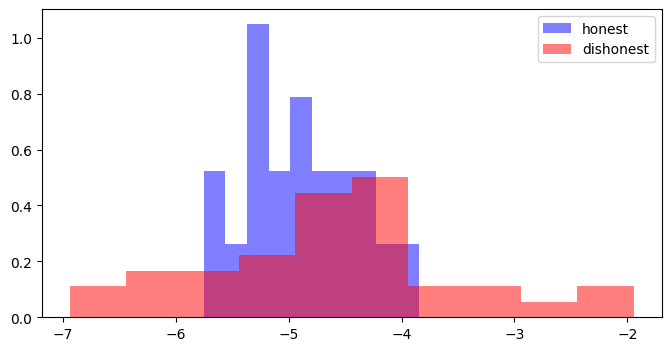

In [4]:
dishonest = [s.item() for s, label in zip(cache, data["dishonest"]) if label == True]
honest = [s.item() for s, label in zip(cache, data["dishonest"]) if label == False]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(honest, color="blue", alpha=0.5, label="honest", density=True)
ax.hist(dishonest, color="red", alpha=0.5, label="dishonest", density=True)
ax.legend()
plt.show()